Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [6]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    subset="training",
    batch_size=batch_size,
    image_size=(img_height,img_width),
    shuffle=True,
    seed=123)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [7]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_test,
    validation_split=0.2,
    subset="validation",
    batch_size=batch_size,
    image_size=(img_height,img_width),
    shuffle=True,
    seed=123)

Found 118 files belonging to 9 classes.
Using 23 files for validation.


In [8]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

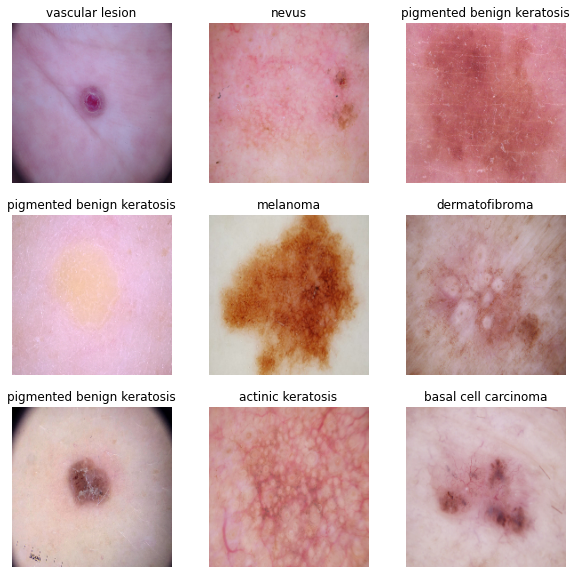

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [11]:
### Your code goes here

from tensorflow.keras import layers

normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.015684064 0.8214536


In [26]:
num_classes = 9

model = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [27]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [35]:
# View the summary of all layers
input_shape = (None, 180, 180, 3)
model.build(input_shape)
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_3 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 178, 178, 32)      896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 89, 89, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 87, 87, 32)        9248      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 43, 43, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 41, 41, 32)        9248      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 20, 20, 32)       

### Train the model

In [36]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 32s 559ms/step - loss: 1.9200 - accuracy: 0.2835 - val_loss: 2.2753 - val_accuracy: 0.1304
Epoch 2/20
56/56 [==============================] - 35s 629ms/step - loss: 1.6398 - accuracy: 0.4085 - val_loss: 2.4255 - val_accuracy: 0.3043
Epoch 3/20
56/56 [==============================] - 31s 554ms/step - loss: 1.4912 - accuracy: 0.4699 - val_loss: 2.4308 - val_accuracy: 0.2174
Epoch 4/20
56/56 [==============================] - 27s 483ms/step - loss: 1.4203 - accuracy: 0.5084 - val_loss: 2.6804 - val_accuracy: 0.3043
Epoch 5/20
56/56 [==============================] - 27s 476ms/step - loss: 1.3423 - accuracy: 0.5363 - val_loss: 2.7428 - val_accuracy: 0.2609
Epoch 6/20
56/56 [==============================] - 27s 482ms/step - loss: 1.2909 - accuracy: 0.5541 - val_loss: 3.0051 - val_accuracy: 0.3043
Epoch 7/20
56/56 [==============================] - 28s 504ms/step - loss: 1.2216 - accuracy: 0.5647 - val_loss: 3.1170 - val_accuracy: 0.3043

### Visualizing training results

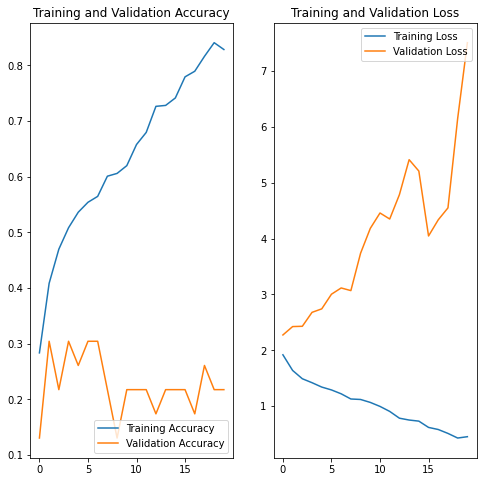

In [37]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [55]:
# model.save('model_1')

INFO:tensorflow:Assets written to: model_1\assets


In [12]:
model = keras.models.load_model("model_1")
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_3 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 178, 178, 32)      896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 89, 89, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 87, 87, 32)        9248      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 43, 43, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 41, 41, 32)        9248      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 20, 20, 32)       

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here

In [38]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
image, label = next(iter(train_ds))

In [39]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])


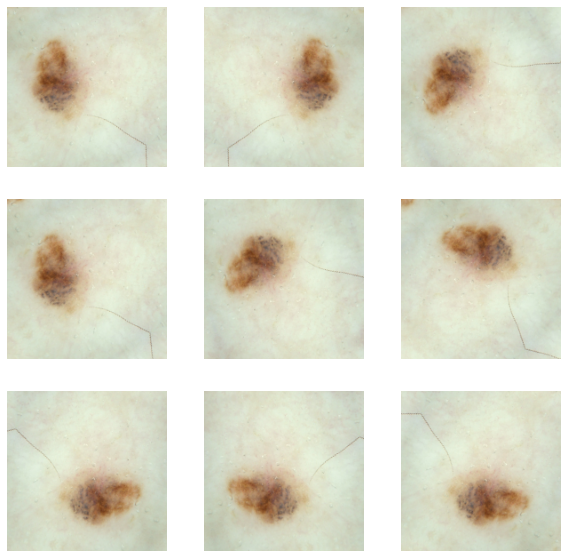

In [40]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(10, 10))
for i in range(9):
    augmented_image = data_augmentation(image)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_image[0].numpy().astype("uint8"))
    plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [67]:
## You can use Dropout layer if there is an evidence of overfitting in your findings
num_classes = 9
## Your code goes here
model = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.Dropout(0.2),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


### Compiling the model

In [68]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [69]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 33s 579ms/step - loss: 2.1122 - accuracy: 0.2243 - val_loss: 2.2645 - val_accuracy: 0.2174
Epoch 2/20
56/56 [==============================] - 31s 559ms/step - loss: 1.8773 - accuracy: 0.3142 - val_loss: 2.3433 - val_accuracy: 0.0870
Epoch 3/20
56/56 [==============================] - 31s 560ms/step - loss: 1.7640 - accuracy: 0.3605 - val_loss: 2.6097 - val_accuracy: 0.0435
Epoch 4/20
56/56 [==============================] - 30s 535ms/step - loss: 1.6311 - accuracy: 0.4191 - val_loss: 3.2079 - val_accuracy: 0.0870
Epoch 5/20
56/56 [==============================] - 30s 541ms/step - loss: 1.5837 - accuracy: 0.4291 - val_loss: 2.2567 - val_accuracy: 0.1304
Epoch 6/20
56/56 [==============================] - 31s 548ms/step - loss: 1.5370 - accuracy: 0.4526 - val_loss: 2.1771 - val_accuracy: 0.2609
Epoch 7/20
56/56 [==============================] - 31s 546ms/step - loss: 1.5459 - accuracy: 0.4515 - val_loss: 2.0355 - val_accuracy: 0.3478

### Visualizing the results

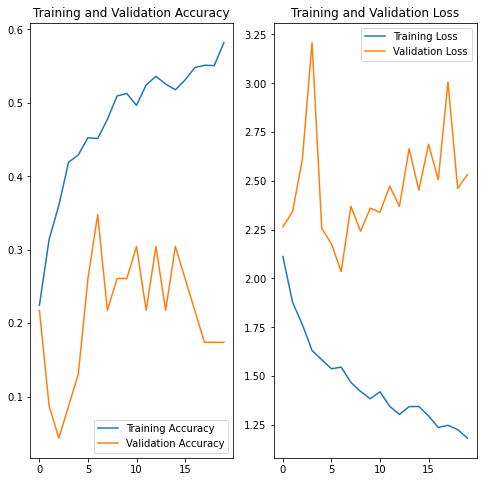

In [70]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

although the model is regualized but there is no significant improvement to it

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [74]:
for label in os.listdir(data_dir_train):
    print(f"{label} : {len(os.listdir(os.path.join(data_dir_train,label)))}")

actinic keratosis : 114
basal cell carcinoma : 376
dermatofibroma : 95
melanoma : 438
nevus : 357
pigmented benign keratosis : 462
seborrheic keratosis : 77
squamous cell carcinoma : 181
vascular lesion : 139


#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
seborrheic keratosis has the least number of samples
#### - Which classes dominate the data in terms proportionate number of samples?
pigmented benign keratosis 

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [75]:
!pip install Augmentor

You should consider upgrading via the 'c:\users\acer\anaconda3\envs\tf_gpu\python.exe -m pip install --upgrade pip' command.


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [80]:
class_names = ['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 #'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

In [82]:
path_to_training_dataset= data_dir_train
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(os.path.join(path_to_training_dataset,i))
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration\Train\actinic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1AB3336C208>: 100%|█| 500/500 [00:04<00:00, 109.44 Samples


Initialised with 376 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration\Train\basal cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1AB54E02688>: 100%|█| 500/500 [00:04<00:00, 104.30 Samples


Initialised with 95 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration\Train\dermatofibroma\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x1AB3D69B1C8>: 100%|█| 500/500 [00:04<00:


Initialised with 438 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration\Train\melanoma\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x1AB331149C8>: 100%|█| 500/500 [00:20<00:00, 24.55 Samples


Initialised with 357 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration\Train\nevus\output.

Processing <PIL.Image.Image image mode=RGB size=919x802 at 0x1AB3310D088>: 100%|█| 500/500 [00:19<00:00, 26.17 Samples/


Initialised with 77 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration\Train\seborrheic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x1AB3D3DAAC8>: 100%|█| 500/500 [00:09<00:00, 53.69 Samples


Initialised with 181 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration\Train\squamous cell carcinoma\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x1AB3D4F4548>: 100%|█| 500/500 [00:04<00:


Initialised with 139 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration\Train\vascular lesion\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1AB47FF3308>: 100%|█| 500/500 [00:03<00:00, 127.62 Samples


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [83]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4000


### Lets see the distribution of augmented data after adding new images to the original training data.

In [91]:
for label in os.listdir(data_dir_train):
    print(f"{label} : {len(os.listdir(os.path.join(data_dir_train,label)))}")

actinic keratosis : 614
basal cell carcinoma : 876
dermatofibroma : 595
melanoma : 938
nevus : 857
pigmented benign keratosis : 462
seborrheic keratosis : 577
squamous cell carcinoma : 681
vascular lesion : 639


So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [92]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [97]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    batch_size=batch_size,
    image_size=(img_height,img_width),
    shuffle=True,
    seed=123)

Found 6239 files belonging to 9 classes.


#### **Todo:** Create a validation dataset

In [99]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_test,
    batch_size=batch_size,
    image_size=(img_height,img_width),
    shuffle=True,
    seed=123)

Found 118 files belonging to 9 classes.


#### **Todo:** Create your model (make sure to include normalization)

In [100]:
## You can use Dropout layer if there is an evidence of overfitting in your findings
num_classes = 9
## Your code goes here
model = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Dropout(0.2),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [101]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [103]:
epochs = 20
## Your code goes here, use 50 epochs.
## Your code goes here, note: train your model for 20 epochs

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
195/195 [==============================] - 111s 566ms/step - loss: 1.7840 - accuracy: 0.3066 - val_loss: 2.4318 - val_accuracy: 0.1441
Epoch 2/20
195/195 [==============================] - 109s 556ms/step - loss: 1.4956 - accuracy: 0.4199 - val_loss: 3.9291 - val_accuracy: 0.1441
Epoch 3/20
195/195 [==============================] - 110s 562ms/step - loss: 1.3091 - accuracy: 0.5031 - val_loss: 3.0910 - val_accuracy: 0.1610
Epoch 4/20
195/195 [==============================] - 109s 558ms/step - loss: 1.1790 - accuracy: 0.5568 - val_loss: 3.6625 - val_accuracy: 0.1356
Epoch 5/20
195/195 [==============================] - 109s 557ms/step - loss: 1.0471 - accuracy: 0.6079 - val_loss: 3.4126 - val_accuracy: 0.1780
Epoch 6/20
195/195 [==============================] - 110s 559ms/step - loss: 0.9451 - accuracy: 0.6483 - val_loss: 3.3305 - val_accuracy: 0.2034
Epoch 7/20
195/195 [==============================] - 109s 558ms/step - loss: 0.8149 - accuracy: 0.7040 - val_loss: 3.4108 -

#### **Todo:**  Visualize the model results

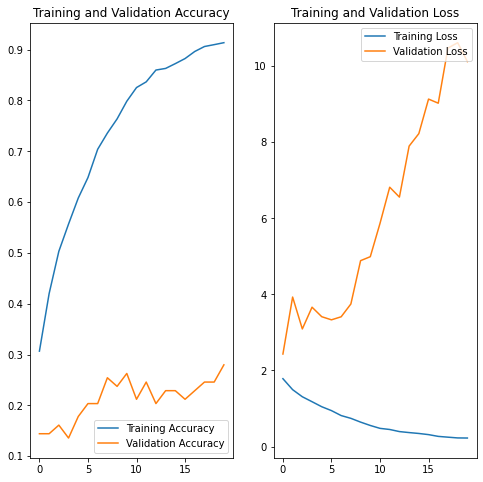

In [104]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



there is an upward trend observed in val accuracy, which shows with more epochs the model could be improved. Also looking at the loss graph, the model could have been further regularized along with keras callbacks to store the best model